In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import heapq

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the possible actions for the drones
ACTIONS = [
    (0, 1),   # Move right
    (1, 0),   # Move down
    (0, -1),  # Move left
    (-1, 0)   # Move up
]

# Simulation parameters
GRID_SIZE = 10  # 10x10 grid
NUM_DRONES = 3  # Number of drones
MAX_STEPS = 50  # Maximum steps for the simulation
ENERGY_CONSUMPTION_PER_MOVE = 1  # Energy consumed per move
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Epsilon-greedy policy for exploration
MIN_EPSILON = 0.01  # Minimum epsilon value for exploration
EPSILON_DECAY = 0.99  # Decay rate for epsilon
INITIAL_BATTERY = 100  # Initial battery percentage for each drone
RECHARGE_THRESHOLD = 20  # Battery level below which drones need to recharge
RECHARGE_STATION = (GRID_SIZE - 1, GRID_SIZE - 1)  # Recharging station location
RECHARGE_TIME = 10  # Number of moves to fully recharge
SAFE_DISTANCE = 1  # Minimum safe distance between drones

# Initialize metrics for tracking simulation performance
accidents_over_time = []  # Track accidents over time
energy_usage_over_time = []  # Track energy usage over time
unique_coverage_over_time = []  # Track unique coverage over time
epsilon_over_time = []  # Track epsilon decay over time
redundant_coverage_over_time = []  # Track redundant coverage over time
collision_rate = []  # Collision rate (accidents per step)
coverage_efficiency = []  # Coverage efficiency (percentage of unique cells covered per move)
success_rate = []  # Success rate for simulations reaching over 90% coverage
cumulative_unique_coverage = []  # Cumulative unique coverage over multiple simulations

# Initialize lists to store results from each simulation
all_accidents_over_time = []
all_energy_usage_over_time = []
all_unique_coverage_over_time = []
all_epsilon_over_time = []
all_redundant_coverage_over_time = []
all_collision_rate = []
all_coverage_efficiency = []
all_success_rate = []

class Environment:
    """
    Environment class to manage the grid and track the state of the simulation.
    """
    def __init__(self, grid_size, num_drones):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))
        self.coverage_count = np.zeros((grid_size, grid_size), dtype=int)
        self.coverage_map = np.zeros((grid_size, grid_size), dtype=int)
        self.drones = [Drone(i, grid_size, INITIAL_BATTERY, RECHARGE_STATION) for i in range(num_drones)]
        self.accidents = 0

    def reset(self):
        """
        Reset the environment to its initial state.
        """
        self.grid.fill(0)
        self.coverage_count.fill(0)
        self.coverage_map.fill(0)
        self.accidents = 0
        for drone in self.drones:
            drone.reset()

    def update_coverage(self, position):
        """
        Update the grid coverage based on drone positions.

        Parameters:
        - position: Tuple, current position of the drone
        """
        x, y = position
        self.grid[x, y] = 1
        self.coverage_count[x, y] += 1
        self.coverage_map[x, y] = 1

    def check_accidents(self):
        """
        Check for accidents where multiple drones occupy the same cell.
        """
        positions = [drone.position for drone in self.drones]
        if len(positions) != len(set(positions)):
            self.accidents += 1

    def step(self):
        """
        Perform a single step in the simulation, updating drone states and grid coverage.
        """
        for drone in self.drones:
            drone.act(self.grid, self.coverage_count, self.coverage_map, self.drones)
            self.update_coverage(drone.position)
        self.check_accidents()


class Drone:
    """
    Drone class representing each agent in the environment.
    """
    def __init__(self, drone_id, grid_size, initial_battery, recharge_station):
        self.id = drone_id
        self.grid_size = grid_size
        self.position = (0, 0)
        self.battery = initial_battery
        self.q_table = np.zeros((grid_size, grid_size, len(ACTIONS)))
        self.epsilon = EPSILON
        self.steps_to_recharge = 0
        self.recharge_station = recharge_station
        self.covered = set()

    def reset(self):
        """
        Reset the drone to its initial state.
        """
        self.position = (0, 0)
        self.battery = INITIAL_BATTERY
        self.steps_to_recharge = 0
        self.epsilon = EPSILON
        self.covered.clear()
        self.q_table.fill(0)

    def update_epsilon(self):
        """
        Decays epsilon over time to reduce exploration as learning progresses.
        """
        self.epsilon = max(MIN_EPSILON, self.epsilon * EPSILON_DECAY)
        epsilon_over_time.append(self.epsilon)

    def choose_action(self, coverage_map):
        """
        Chooses an action based on an epsilon-greedy policy, prioritizing unexplored cells.

        Parameters:
        - coverage_map: 2D numpy array representing the coverage status of the grid

        Returns:
        - Int, index of the chosen action
        """
        x, y = self.position

        if random.uniform(0, 1) < self.epsilon:
            # Explore: choose a random action
            return random.randint(0, len(ACTIONS) - 1)
        else:
            # Exploit: choose the best action based on Q-table
            uncovered_actions = [(i, (x + dx, y + dy)) for i, (dx, dy) in enumerate(ACTIONS)
                                 if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size and coverage_map[x + dx, y + dy] == 0]
            if uncovered_actions:
                # Prefer actions that lead to uncovered cells
                return random.choice([action[0] for action in uncovered_actions])
            else:
                # If all adjacent cells are covered, choose based on Q-table
                return np.argmax(self.q_table[x, y])

    def act(self, grid, coverage_count, coverage_map, drones):
        """
        Execute an action based on the chosen policy and update the drone's state.

        Parameters:
        - grid: 2D numpy array representing the grid
        - coverage_count: 2D numpy array tracking the number of times each cell is covered
        - coverage_map: 2D numpy array indicating whether each cell is covered
        - drones: List of Drone objects representing all drones in the simulation
        """
        global total_recharge_time, total_recharging_drones, total_recharge_events, accidents

        if self.battery <= 0:
            return  # Can't move if out of battery

        if self.steps_to_recharge > 0:
            # Handle recharging
            self.steps_to_recharge -= 1
            if self.steps_to_recharge == 0:
                self.battery = INITIAL_BATTERY
                total_recharging_drones += 1
            return

        if self.battery < RECHARGE_THRESHOLD:
            path_to_recharge = a_star_path(self.position, self.recharge_station, self.grid_size)
            if path_to_recharge:
                next_position = path_to_recharge[0]
                if next_position == self.recharge_station:
                    self.steps_to_recharge = RECHARGE_TIME
                    total_recharge_events += 1
                else:
                    self.position = next_position
            else:
                dx, dy = np.sign(self.recharge_station[0] - self.position[0]), np.sign(self.recharge_station[1] - self.position[1])
                self.position = (self.position[0] + dx, self.position[1] + dy)
            self.battery -= ENERGY_CONSUMPTION_PER_MOVE
            return

        action = self.choose_action(coverage_map)
        dx, dy = ACTIONS[action]
        new_position = (self.position[0] + dx, self.position[1] + dy)

        if not (0 <= new_position[0] < self.grid_size and 0 <= new_position[1] < self.grid_size):
            return  # Stay in place if out of bounds

        # Check for safe distance from other drones
        if any(np.linalg.norm(np.array(new_position) - np.array(drone.position)) < SAFE_DISTANCE for drone in drones if drone.id != self.id):
            return  # Skip move if it's not safe

        # Check for accidents (drones in the same grid cell)
        if any(drone.position == new_position for drone in drones if drone.id != self.id):
            accidents += 1
            return  # Skip move if another drone is already there

        # Calculate reward and update Q-table
        reward = 10 if new_position not in self.covered else -5
        reward -= ENERGY_CONSUMPTION_PER_MOVE
        old_q_value = self.q_table[self.position[0], self.position[1], action]
        future_q_value = np.max(self.q_table[new_position[0], new_position[1]])
        self.q_table[self.position[0], self.position[1], action] = (1 - ALPHA) * old_q_value + ALPHA * (reward + GAMMA * future_q_value)

        # Update position, battery, and coverage
        self.position = new_position
        self.battery -= ENERGY_CONSUMPTION_PER_MOVE
        self.covered.add(self.position)
        grid[self.position] = 1
        coverage_count[self.position] += 1
        coverage_map[self.position] = 1
        self.update_epsilon()  # Update epsilon adaptively


class MARL:
    """
    Multi-Agent Reinforcement Learning class to manage learning across multiple drones.
    """
    def __init__(self, environment):
        self.environment = environment

    def train(self, max_steps):
        """
        Train the drone swarm using MARL over a specified number of steps.

        Parameters:
        - max_steps: Int, maximum number of steps for the simulation
        """
        cumulative_energy_used = 0
        total_accidents = 0

        for step in range(max_steps):
            self.environment.step()
            
            # Track accidents, energy usage, and redundant coverage over time
            total_accidents += self.environment.accidents
            collision_rate.append(total_accidents / (step + 1)) # Calculate collision rate (accidents per step)
            
            current_coverage = np.sum(self.environment.grid)
            cumulative_unique_coverage.append(current_coverage)
            
            # Calculate coverage efficiency (percentage of unique cells covered per move)
            if step > 0:
                efficiency = current_coverage / step
                coverage_efficiency.append(efficiency)

            accidents_over_time.append(self.environment.accidents)
            cumulative_energy_used += sum(INITIAL_BATTERY - drone.battery for drone in self.environment.drones)
            energy_usage_over_time.append(cumulative_energy_used)
            unique_coverage_over_time.append(np.sum(self.environment.grid))
            redundant_coverage_over_time.append(np.sum(self.environment.coverage_count) - np.sum(self.environment.grid))

            if np.all(self.environment.grid):
                print(f"All cells covered in {step + 1} steps")
                break
        
        # Calculate success rate (percentage of simulations reaching over 90% coverage)
        if current_coverage >= 0.9 * (self.environment.grid_size * self.environment.grid_size):
            success_rate.append(1)
        else:
            success_rate.append(0)

def a_star_path(start, goal, grid_size):
    """
    Returns the shortest path from start to goal using A* algorithm.
    
    Parameters:
    - start: Tuple, starting coordinates (x, y)
    - goal: Tuple, goal coordinates (x, y)
    - grid_size: Int, size of the grid

    Returns:
    - List of tuples representing the path from start to goal.
    """
    def heuristic(a, b):
        """Heuristic function for A* (Manhattan distance)."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        for dx, dy in ACTIONS:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size:
                tentative_g_score = g_score[current] + 1
                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return []


def generate_start_positions(num_positions, grid_size):
    """
    Generates random start positions for drones on the grid.

    Parameters:
    - num_positions: Int, number of positions to generate
    - grid_size: Int, size of the grid

    Returns:
    - List of tuples representing start positions.
    """
    positions = set()
    while len(positions) < num_positions:
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        positions.add((x, y))
    return list(positions)

# Initialize environment and MARL
environment = Environment(GRID_SIZE, NUM_DRONES)
marl = MARL(environment)

# Train the swarm with MARL
marl.train(MAX_STEPS)

In [2]:
# Collect results
unique_covered_cells = np.sum(environment.grid)
total_visits = np.sum(environment.coverage_count)
grid_coverage_percentage = (unique_covered_cells / (GRID_SIZE * GRID_SIZE)) * 100
redundant_coverage = total_visits - unique_covered_cells
redundant_coverage_percentage = (redundant_coverage / total_visits) * 100 if total_visits > 0 else 0

energy_used = sum(INITIAL_BATTERY - drone.battery for drone in environment.drones)
energy_efficiency = energy_used / unique_covered_cells if unique_covered_cells > 0 else float('inf')
energy_used_percentage = (energy_used / (NUM_DRONES * INITIAL_BATTERY)) * 100

# Print metrics
print(f"Total covered cells: {unique_covered_cells}")
print(f"Total energy used: {energy_used}")
print(f"Percentage of grid covered: {grid_coverage_percentage:.2f}%")
print(f"Redundant coverage: {redundant_coverage}")
print(f"Percentage of redundant coverage: {redundant_coverage_percentage:.2f}%")
print(f"Energy Efficiency (energy per covered cell): {energy_efficiency:.2f}")
print(f"Energy used out of total available energy: {energy_used_percentage:.2f}%")
print(f"Number of accidents (drones in the same cell): {environment.accidents}")

# Print new metrics
if len(collision_rate) > 0:
    avg_collision_rate = sum(collision_rate) / len(collision_rate)
else:
    avg_collision_rate = 0
print(f"Average Collision Rate (accidents per step): {avg_collision_rate:.2f}")

if len(coverage_efficiency) > 0:
    avg_coverage_efficiency = sum(coverage_efficiency) / len(coverage_efficiency)
else:
    avg_coverage_efficiency = 0
print(f"Average Coverage Efficiency (percentage of unique cells covered per move): {avg_coverage_efficiency:.2f}%")

Total covered cells: 94.0
Total energy used: 141
Percentage of grid covered: 94.00%
Redundant coverage: 197.0
Percentage of redundant coverage: 67.70%
Energy Efficiency (energy per covered cell): 1.50
Energy used out of total available energy: 47.00%
Number of accidents (drones in the same cell): 0
Average Collision Rate (accidents per step): 0.00
Average Coverage Efficiency (percentage of unique cells covered per move): 2.72%


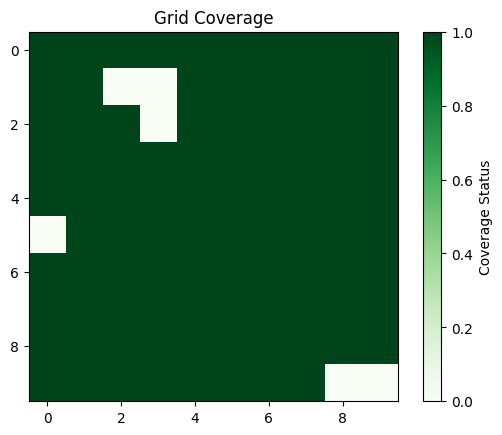

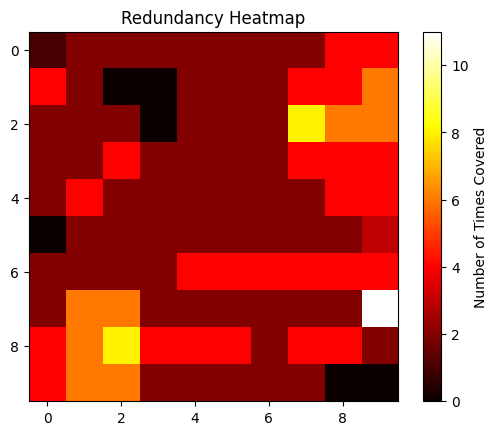

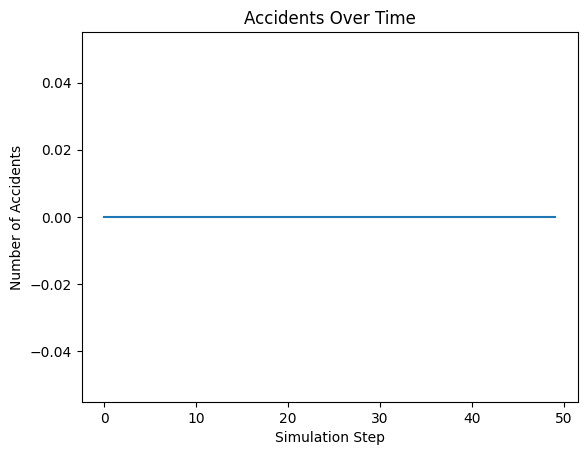

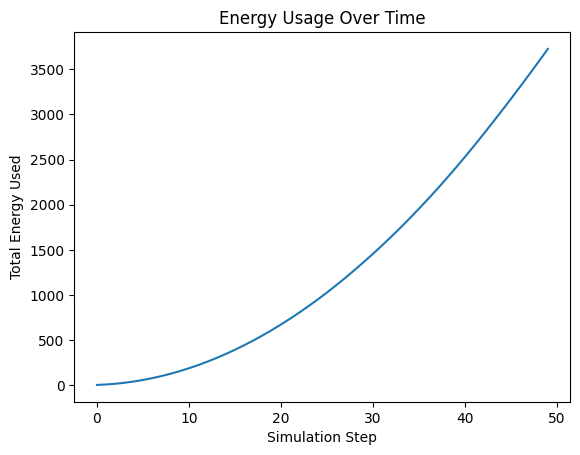

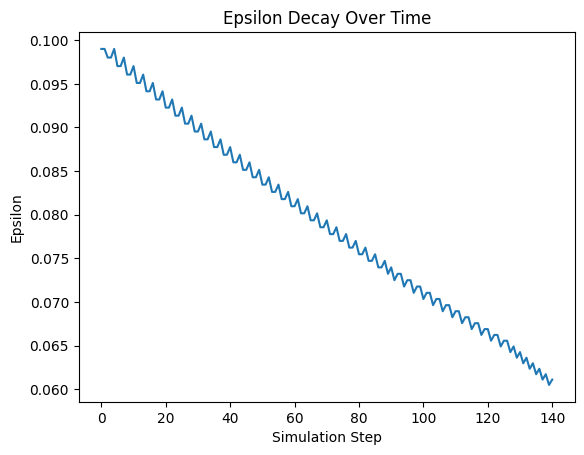

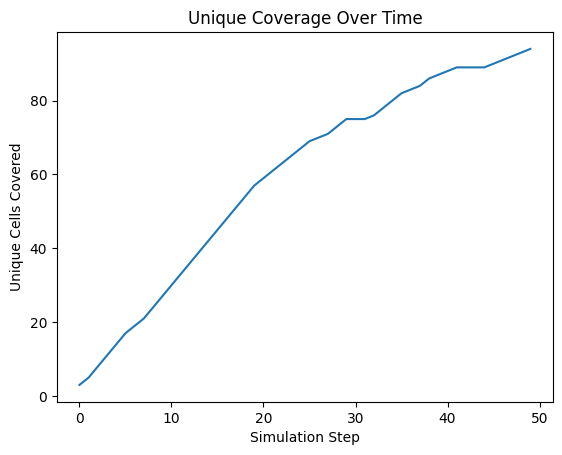

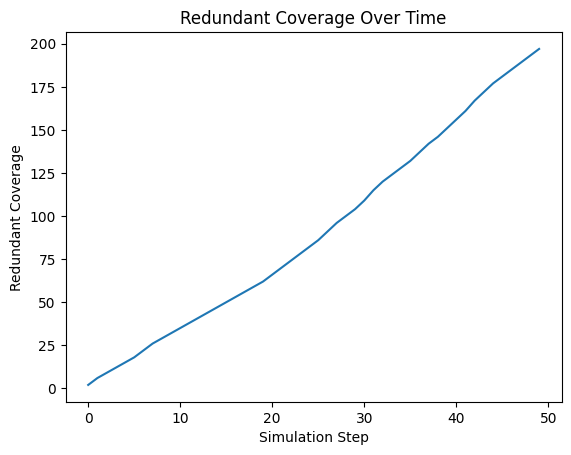

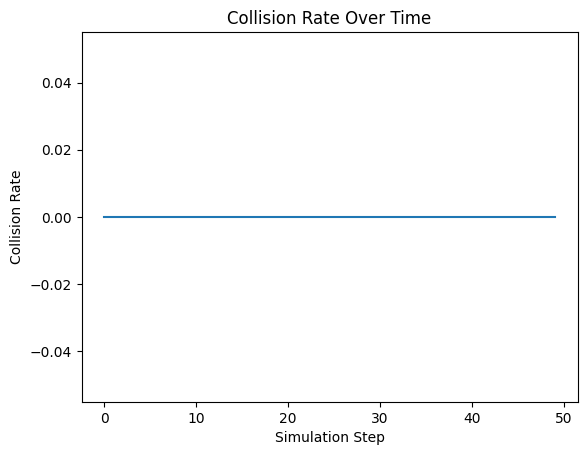

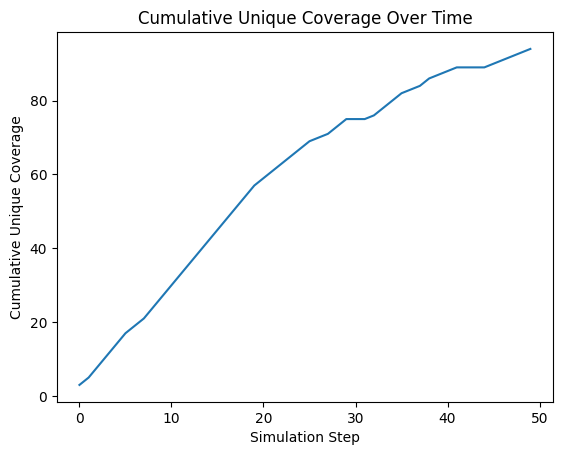

In [3]:
#Visualizations

# 1. Coverage Heatmap
plt.imshow(environment.grid, cmap='Greens')
plt.title('Grid Coverage')
plt.colorbar(label='Coverage Status')
plt.show()

# 2. Redundancy Heatmap
plt.imshow(environment.coverage_count, cmap='hot', interpolation='nearest')
plt.title('Redundancy Heatmap')
plt.colorbar(label='Number of Times Covered')
plt.show()

# 3. Accidents Over Time
plt.plot(accidents_over_time)
plt.title('Accidents Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Number of Accidents')
plt.show()

# 4. Energy Usage Over Time
plt.plot(energy_usage_over_time)
plt.title('Energy Usage Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Total Energy Used')
plt.show()

# 5. Epsilon Decay Over Time
plt.plot(epsilon_over_time)
plt.title('Epsilon Decay Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Epsilon')
plt.show()

# 6. Unique Coverage Over Time
plt.plot(unique_coverage_over_time)
plt.title('Unique Coverage Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Unique Cells Covered')
plt.show()

# 7. Redundant Coverage Over Time
plt.plot(redundant_coverage_over_time)
plt.title('Redundant Coverage Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Redundant Coverage')
plt.show()

# 8. Collision Rate Over Time
plt.plot(collision_rate)
plt.title('Collision Rate Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Collision Rate')
plt.show()

# 9. Cumulative Unique Coverage Over Time
plt.plot(cumulative_unique_coverage)
plt.title('Cumulative Unique Coverage Over Time')
plt.xlabel('Simulation Step')
plt.ylabel('Cumulative Unique Coverage')
plt.show()

In [4]:
# Number of simulations to run
NUM_SIMULATIONS = 100

# Initialize lists to store results from each simulation
all_accidents_over_time = []
all_energy_usage_over_time = []
all_unique_coverage_over_time = []
all_epsilon_over_time = []
all_redundant_coverage_over_time = []
all_collision_rate = []
all_coverage_efficiency = []
all_success_rate = []

for simulation in range(NUM_SIMULATIONS):
    # Initialize environment and MARL
    environment = Environment(GRID_SIZE, NUM_DRONES)
    marl = MARL(environment)

    # Train the swarm with MARL
    marl.train(MAX_STEPS)

    # Store metrics for each simulation
    all_accidents_over_time.append(accidents_over_time[:])
    all_energy_usage_over_time.append(energy_usage_over_time[:])
    all_unique_coverage_over_time.append(unique_coverage_over_time[:])
    all_epsilon_over_time.append(epsilon_over_time[:])
    all_redundant_coverage_over_time.append(redundant_coverage_over_time[:])
    all_collision_rate.append(collision_rate[:])
    all_coverage_efficiency.append(coverage_efficiency[:])
    all_success_rate.append(success_rate[:])

    # Reset lists for the next simulation
    accidents_over_time = []
    energy_usage_over_time = []
    unique_coverage_over_time = []
    epsilon_over_time = []
    redundant_coverage_over_time = []
    collision_rate = []
    coverage_efficiency = []
    success_rate = []

# After all simulations, calculate averages or summaries
avg_collision_rate = np.mean([np.mean(rate) for rate in all_collision_rate if rate])
avg_coverage_efficiency = np.mean([np.mean(efficiency) for efficiency in all_coverage_efficiency if efficiency])
# overall_success_rate = np.mean([np.mean(success) for success in all_success_rate if success])

print(f"Average Collision Rate (accidents per step) across all simulations: {avg_collision_rate:.2f}%")
print(f"Average Coverage Efficiency (percentage of unique cells covered per move) across all simulations: {avg_coverage_efficiency:.2f}%")

All cells covered in 43 steps
All cells covered in 49 steps
Average Collision Rate (accidents per step) across all simulations: 0.01%
Average Coverage Efficiency (percentage of unique cells covered per move) across all simulations: 2.54%
